Sveučilište u Zagrebu  
Fakultet elektrotehnike i računarstva  
  
## Strojno učenje 2020/2021  
http://www.fer.unizg.hr/predmet/su

------------------------------

### Laboratorijska vježba 3: Stroj potpornih vektora i algoritam k-najbližih susjeda

*Verzija: 0.5  
Zadnji put ažurirano: 30. studenog 2020.*

(c) 2015-2020 Jan Šnajder, Domagoj Alagić  

Rok za predaju: **7. prosinca 2020. u 06:00h**  

------------------------------

### Upute

Treća laboratorijska vježba sastoji se od sedam zadataka. U nastavku slijedite upute navedene u ćelijama s tekstom. Rješavanje vježbe svodi se na **dopunjavanje ove bilježnice**: umetanja ćelije ili više njih **ispod** teksta zadatka, pisanja odgovarajućeg kôda te evaluiranja ćelija. 

Osigurajte da u potpunosti **razumijete** kôd koji ste napisali. Kod predaje vježbe, morate biti u stanju na zahtjev asistenta (ili demonstratora) preinačiti i ponovno evaluirati Vaš kôd. Nadalje, morate razumjeti teorijske osnove onoga što radite, u okvirima onoga što smo obradili na predavanju. Ispod nekih zadataka možete naći i pitanja koja služe kao smjernice za bolje razumijevanje gradiva (**nemojte pisati** odgovore na pitanja u bilježnicu). Stoga se nemojte ograničiti samo na to da riješite zadatak, nego slobodno eksperimentirajte. To upravo i jest svrha ovih vježbi.

Vježbe trebate raditi **samostalno** ili u **tandemu**. Možete se konzultirati s drugima o načelnom načinu rješavanja, ali u konačnici morate sami odraditi vježbu. U protivnome vježba nema smisla.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
def plot_2d_clf_problem(X, y, h=None):
    '''
    Plots a two-dimensional labeled dataset (X,y) and, if function h(x) is given, 
    the decision surfaces.
    '''
    assert X.shape[1] == 2, "Dataset is not two-dimensional"
    if h!=None : 
        # Create a mesh to plot in
        r = 0.03  # mesh resolution
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, r),
                             np.arange(y_min, y_max, r))
        XX=np.c_[xx.ravel(), yy.ravel()]
        try:
            Z_test = h(XX)
            if Z_test.shape == ():
                # h returns a scalar when applied to a matrix; map explicitly
                Z = np.array(list(map(h,XX)))
            else :
                Z = Z_test
        except ValueError:
            # can't apply to a matrix; map explicitly
            Z = np.array(list(map(h,XX)))
        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, cmap=plt.cm.Pastel1)

    # Plot the dataset
    plt.scatter(X[:,0],X[:,1], c=y, cmap=plt.cm.tab20b, marker='o', s=50);
    
def plot_2d_svc_problem(X, y, svc=None):
    '''
    Plots a two-dimensional labeled dataset (X,y) and, if SVC object is given, 
    the decision surfaces (with margin as well).
    '''
    assert X.shape[1] == 2, "Dataset is not two-dimensional"
    if svc!=None : 
        # Create a mesh to plot in
        r = 0.03  # mesh resolution
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, r),
                             np.arange(y_min, y_max, r))
        XX=np.c_[xx.ravel(), yy.ravel()]
        Z = np.array([svc_predict(svc, x) for x in XX])
        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, cmap=plt.cm.Pastel1)

    # Plot the dataset
    plt.scatter(X[:,0],X[:,1], c=y, cmap=plt.cm.Paired, marker='o', s=50)

def svc_predict(svc, x) : 
    h = svc.decision_function([x])
    if np.isclose(h, 0, atol=0.03):
        return 5
    elif (h >= -1 and h < -0.03) or (h > 0.03 and h <= 1):
        return 0.5
    else: 
        return max(-1, min(1, h))
    
def plot_error_surface(err, c_range=(0,5), g_range=(0,5)):
    c1, c2 = c_range[0], c_range[1]
    g1, g2 = g_range[0], g_range[1]
    plt.xticks(range(0,g2-g1+1,5),range(g1,g2+1,5)); plt.xlabel("gamma")
    plt.yticks(range(0,c2-c1+1,5),range(c1,c2+1,5)); plt.ylabel("C")
    p = plt.contour(err);
    plt.imshow(1-err, interpolation='bilinear', origin='lower',cmap=plt.cm.gray)
    plt.clabel(p, inline=1, fontsize=10)
    
def knn_eval(n_instances=100, n_features=2, n_classes=2, n_informative=2, 
             test_size=0.3, k_range=(1, 20), n_trials=40):
    
    train_errors = []
    test_errors = []
    ks = list(range(k_range[0], k_range[1] + 1))

    for i in range(0, n_trials):
        X, y = make_classification(n_instances, n_features, n_classes=n_classes, 
                                   n_informative=n_informative, n_redundant=0, n_clusters_per_class=1)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
        train = []
        test = []
        for k in ks:
            knn = KNeighborsClassifier(n_neighbors=k)
            knn.fit(X_train, y_train)
            train.append(1 - knn.score(X_train, y_train))
            test.append(1 - knn.score(X_test, y_test))
        train_errors.append(train)
        test_errors.append(test)
        
    train_errors = np.mean(np.array(train_errors), axis=0)
    test_errors = np.mean(np.array(test_errors), axis=0)
    best_k = ks[np.argmin(test_errors)]
    
    return ks, best_k, train_errors, test_errors

### 1. Klasifikator stroja potpornih vektora (SVM)

#### (a)

Upoznajte se s razredom [`svm.SVC`](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html), koja ustvari implementira sučelje prema implementaciji [`libsvm`](http://www.csie.ntu.edu.tw/~cjlin/libsvm/). Primijenite model `SVC` s linearnom jezgrenom funkcijom (tj. bez preslikavanja primjera u prostor značajki) na skup podataka `seven` (dan niže) s $N=7$ primjera. Ispišite koeficijente $w_0$ i $\mathbf{w}$. Ispišite dualne koeficijente i potporne vektore. Završno, koristeći funkciju `plot_2d_svc_problem` iscrtajte podatke, decizijsku granicu i marginu. Funkcija prima podatke, oznake i klasifikator (objekt klase `SVC`). 

In [3]:
from sklearn.svm import SVC

seven_X = np.array([[2,1], [2,3], [1,2], [3,2], [5,2], [5,4], [6,3]])
seven_y = np.array([1, 1, 1, 1, -1, -1, -1])

Tezine w: [[-9.99707031e-01 -2.92968750e-04]]
Tezine w0: [3.99951172]
Tezine dual: [[-4.99707031e-01 -1.46484375e-04  4.99853516e-01]]
Tezine granicne tocke potpornih vektora:
[[5. 2.]
 [5. 4.]
 [3. 2.]]
Tezine potporni vektori: [4 5 3]



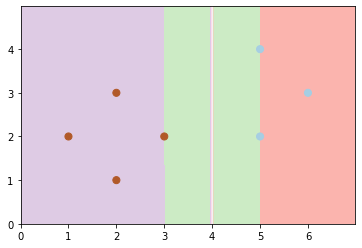

In [5]:
# Vaš kôd ovdje...

svc_1a = SVC(kernel = 'linear') # definiranje SVC-a s linearnom jezgrenom funkcijom
svc_1a.fit(seven_X, seven_y) # treniranje modela s skupu seven

W_1a = svc_1a.coef_ # keoficijenti w
W0_1a = svc_1a.intercept_ # keoficijent w0
dual_coef_1a = svc_1a.dual_coef_ # dualni koeficijenti
support_vector_1a = svc_1a.support_vectors_ # potporni granicne točke potpornih vektora
support_1a = svc_1a.support_ # potporni vektori

print("Tezine w: {}".format(W_1a)) # ispis keoficijenata w
print("Tezine w0: {}".format(W0_1a)) # ispis keoficijeniti w0
print("Tezine dual: {}".format(dual_coef_1a)) # ispis dualni koeficijenta
print("Tezine granicne tocke potpornih vektora:\n{}".format(support_vector_1a)) # ispis potporni granicne točke potpornih vektora
print("Tezine potporni vektori: {}".format(support_1a)) # ispis potpornih vektora

plot_2d_svc_problem(seven_X, seven_y, svc_1a) # iscrtavanje podatka, decizijske granice i margine za skup seven
print()

**Q:** Koji primjeri su potporni vektori i zašto?

#### (b)

Definirajte funkciju `hinge(model, x, y)` koja izračunava gubitak zglobnice modela SVM na primjeru `x`. Izračunajte gubitke modela naučenog na skupu `seven` za primjere $\mathbf{x}^{(2)}=(3,2)$ i $\mathbf{x}^{(1)}=(3.5,2)$ koji su označeni pozitivno ($y=1$) te za $\mathbf{x}^{(3)}=(4,2)$ koji je označen negativno ($y=-1$). Također, izračunajte prosječni gubitak SVM-a na skupu `seven`. Uvjerite se da je rezultat identičan onome koji biste dobili primjenom ugrađene funkcije [`metrics.hinge_loss`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.hinge_loss.html).

In [6]:
from sklearn.metrics import hinge_loss

# Vaš kôd ovdje...

# izracun funkcije gubitka zglobnice
def hinge(model, x, y):
    hx = model.decision_function(x) # izracun h(x) iz x
    error = 1 - y * hx 
    L = max(0, error)
    return L

# izracun srednje vrijednosti funkcije pogreske zglobnice
def average_hinge_loss(model, X, Y):
    sum = 0
    for i in range(len(X)):
        newL = hinge(model, [X[i]], Y[i])
    
        sum += newL
    
    average_L = sum/len(X)
    return average_L

#=====================================================================    
# izracun 1. primjera

x1_1b = [[3.5, 2]] # definiranje 1. X
y1_1b = 1 # definirene 1. y

L1_1b = hinge(svc_1a, x1_1b, y1_1b) # izracun funkcije gubitka L1
 
print("x1 = {}, y1 = {}, L1 = {}".format(x1_1b, y1_1b, L1_1b)) # ispis 1. prijera
#======================================================================
# izracun 2. primjera

x2_1b = [[3, 2]] # definiranje 2. X
y2_1b = 1 # definirene 2. y

L2_1b = hinge(svc_1a, x2_1b, y2_1b) # izracun funkcije gubitka L2

print("x2 = {}, y2 = {}, L2 = {}".format(x2_1b, y2_1b, L2_1b)) # ispis 2. prijera
#=====================================================================
# izracun 3. primjera

x3_1b = [[4, 2]] # definiranje 3. X
y3_1b = -1 # definirene 3. y

L3_1b = hinge(svc_1a, x3_1b, y3_1b) # izracun funkcije gubitka L3

print("x3 = {}, y3 = {}, L3 = {}".format(x3_1b, y3_1b, L3_1b)) # ispis 3. prijera
#=====================================================================

my_average_hinge_loss = average_hinge_loss(svc_1a, seven_X, seven_y) # izracun vrijednosti funkcije pogreske

print("My average loss: {}".format(my_average_hinge_loss)) # ispis moje funkcije pogreske

seven_hx_1b = svc_1a.decision_function(seven_X) # izracun h(X) za sve primjere skupa X

average_hinge_loss = hinge_loss(seven_y, seven_hx_1b) # izracun funkcije pogreske

print("Average loss: {}".format(average_hinge_loss)) # ispis funkcije pogreske

x1 = [[3.5, 2]], y1 = 1, L1 = [0.50004883]
x2 = [[3, 2]], y2 = 1, L2 = [0.00019531]
x3 = [[4, 2]], y3 = -1, L3 = [1.00009766]
My average loss: [8.37053571e-05]
Average loss: 8.37053571429079e-05


#### (c)

Vratit ćemo se na skupove podataka `outlier` ($N=8$) i `unsep` ($N=8$) iz prošle laboratorijske vježbe (dani niže) i pogledati kako se model SVM-a nosi s njima. Naučite ugrađeni model SVM-a (s linearnom jezgrom) na ovim podatcima i iscrtajte decizijsku granicu (skupa s marginom). Također ispišite točnost modela korištenjem funkcije [`metrics.accuracy_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html).

In [7]:
from sklearn.metrics import accuracy_score

outlier_X = np.append(seven_X, [[12,8]], axis=0)
outlier_y = np.append(seven_y, -1)

unsep_X = np.append(seven_X, [[2,2]], axis=0)
unsep_y = np.append(seven_y, -1)

Accuracy score outliner: 1.0
Accuracy score unsep: 0.875


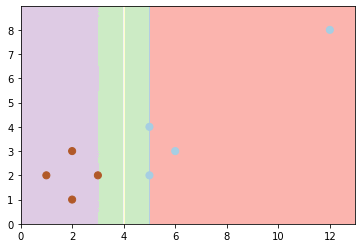

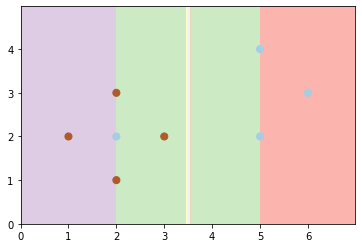

In [9]:
# Vaš kôd ovdje...

svc_outlier_1c = SVC(kernel = 'linear')  # definiranje SVC-a s linearnom jezgrenom funkcijom
svc_outlier_1c.fit(outlier_X, outlier_y) # treniranje modela s skupu outlier

outlier_hx_1c = svc_outlier_1c.predict(outlier_X) # izracun h(X) za sve primjere skupa outlier

accuracy_score_outlier_1c = accuracy_score(outlier_y, outlier_hx_1c) # izracun preciznosti s metodom accuracy_score za outlier

print("Accuracy score outliner: {}".format(accuracy_score_outlier_1c)) # ispis izracun preciznosti s metodom accuracy_score za outlier

plot_2d_svc_problem(outlier_X, outlier_y, svc_outlier_1c) # iscrtavanje podatka, decizijske granice i margine za skup outlier
plt.figure()

#====================================================================
svc_unsep_1c = SVC(kernel = 'linear')  # definiranje SVC-a s linearnom jezgrenom funkcijom
svc_unsep_1c.fit(unsep_X, unsep_y) # treniranje modela s skupu unsep

unsep_hx_1c = svc_unsep_1c.predict(unsep_X) # izracun h(X) za sve primjere skupa unsep

accuracy_score_unsep_1c = accuracy_score(unsep_y, unsep_hx_1c) # izracun preciznosti s metodom accuracy_score za unsep

print("Accuracy score unsep: {}".format(accuracy_score_unsep_1c))  # ispis izracun preciznosti s metodom accuracy_score za unsep

plot_2d_svc_problem(unsep_X, unsep_y, svc_unsep_1c) # iscrtavanje podatka, decizijske granice i margine za skup unsep

**Q:** Kako stršeća vrijednost utječe na SVM?  
**Q:** Kako se linearan SVM nosi s linearno neodvojivim skupom podataka?

### 2. Nelinearan SVM

Ovaj zadatak pokazat će kako odabir jezgre utječe na kapacitet SVM-a. Na skupu `unsep` iz prošlog zadatka trenirajte tri modela SVM-a s različitim jezgrenim funkcijama: linearnom, polinomijalnom i radijalnom baznom (RBF) funkcijom. Varirajte hiperparametar $C$ po vrijednostima $C\in\{10^{-2},1,10^2\}$, dok za ostale hiperparametre (stupanj polinoma za polinomijalnu jezgru odnosno hiperparametar $\gamma$ za jezgru RBF) koristite podrazumijevane vrijednosti. Prikažite granice između klasa (i margine) na grafikonu organiziranome u polje $3x3$, gdje su stupci različite jezgre, a retci različite vrijednosti parametra $C$.

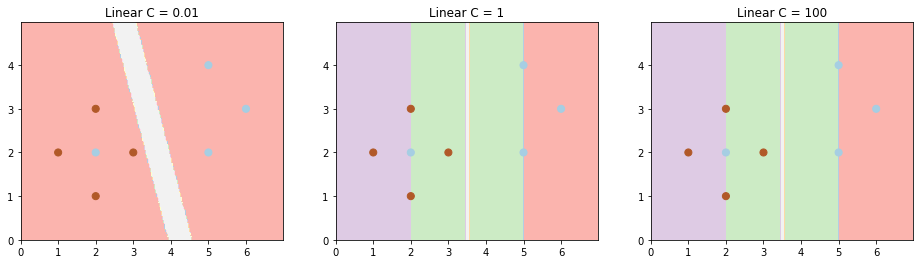

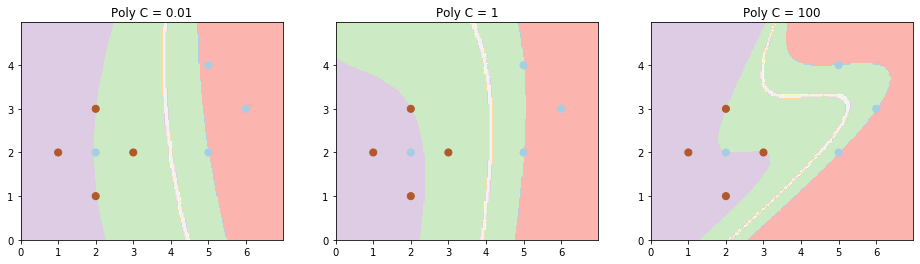

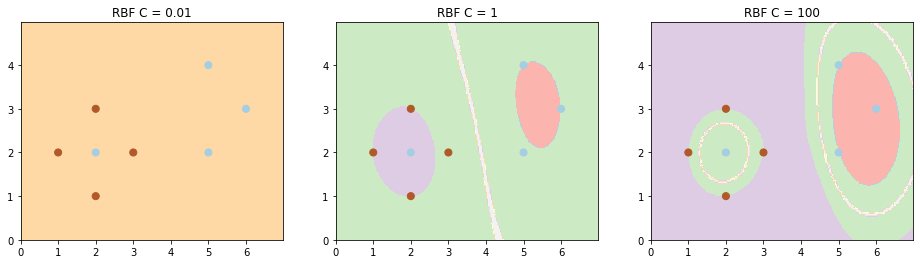

In [11]:
# Vaš kôd ovdje...
C_2 = [0.01, 1, 100] # definiranje hiperparametara C

# treniranje modela s linearnom baznom funkcijom
plt.figure(figsize = (16, 4)) # deiniranje velicine slike

for i in range(len(C_2)):
    svc_2_linear = SVC(C = C_2[i], kernel = 'linear') # definiranje SVC-a s linearnom jezgrenom funkcijom za svaki C
    svc_2_linear.fit(unsep_X, unsep_y) # treniranje modela unsep linearno sa svakim C
    
    # iscrtavanje podatka i margine za linearnu funkciju za svaki C 
    subplot(1, 3, i+1)
    plot_2d_svc_problem(unsep_X, unsep_y, svc_2_linear)
    plt.title("Linear C = {}".format(C_2[i]))
    
#===========================================================================================    
# treniranje modela s polinomijalnom baznom funkcijom
plt.figure(figsize = (16, 4))  # deiniranje velicine slike

for i in range(len(C_2)):
    svc_2_poly = SVC(C = C_2[i], kernel = 'poly') # definiranje SVC-a s polinomijalnom jezgrenom funkcijom za svaki C
    svc_2_poly.fit(unsep_X, unsep_y) # treniranje modela unsep polinomijalno sa svakim C
    
    # iscrtavanje podatka i margine za polinomijalnu funkciju za svaki C 
    subplot(1, 3, i+1)
    plot_2d_svc_problem(unsep_X, unsep_y, svc_2_poly)
    plt.title("Poly C = {}".format(C_2[i]))

#===========================================================================================    
# treniranje modela s radijalnom baznom funkcijom
plt.figure(figsize = (16, 4)) # deiniranje velicine slike    

for i in range(len(C_2)):
    svc_2_rbf = SVC(C = C_2[i], kernel = 'rbf') # definiranje SVC-a s radijalnom jezgrenom funkcijom za svaki C
    svc_2_rbf.fit(unsep_X, unsep_y) # treniranje modela unsep radijalno sa svakim C
    
    # iscrtavanje podatka i margine za radijalnu funkciju za svaki C 
    subplot(1, 3, i+1)
    plot_2d_svc_problem(unsep_X, unsep_y, svc_2_rbf)
    plt.title("RBF C = {}".format(C_2[i]))
    
#===========================================================================================
print()

### 3. Optimizacija hiperparametara SVM-a

Pored hiperparametra $C$, model SVM s jezgrenom funkcijom RBF ima i dodatni hiperparametar $\gamma=\frac{1}{2\sigma^2}$ (preciznost). Taj parametar također određuje složenost modela: velika vrijednost za $\gamma$ znači da će RBF biti uska, primjeri će biti preslikani u prostor u kojem su (prema skalarnome produktu) međusobno vrlo različiti, što će rezultirati složenijim modelima. Obrnuto, mala vrijednost za $\gamma$ znači da će RBF biti široka, primjeri će biti međusobno sličniji, što će rezultirati jednostavnijim modelima. To ujedno znači da, ako odabremo veći $\gamma$, trebamo jače regularizirati model, tj. trebamo odabrati manji $C$, kako bismo spriječili prenaučenost. Zbog toga je potrebno zajednički optimirati hiperparametre $C$ i $\gamma$, što se tipično radi iscrpnim pretraživanjem po rešetci (engl. *grid search*). Ovakav pristup primjenjuje se kod svih modela koji sadrže više od jednog hiperparametra.


#### (a)

Definirajte funkciju 

> `grid_search(X_train, X_validate, y_train, y_validate, c_range=(c1,c2), g_range=(g1,g2), error_surface=False)` 

koja optimizira parametre $C$ i $\gamma$ pretraživanjem po rešetci. Funkcija treba pretražiti hiperparametre $C\in\{2^{c_1},2^{c_1+1},\dots,2^{c_2}\}$ i $\gamma\in\{2^{g_1},2^{g_1+1},\dots,2^{g_2}\}$. Funkcija treba vratiti optimalne hiperparametre $(C^*,\gamma^*)$, tj. one za koje na skupu za provjeru model ostvaruju najmanju pogrešku. Dodatno, ako je `surface=True`, funkcija treba vratiti matrice (tipa `ndarray`) pogreške modela (očekivanje gubitka 0-1) na skupu za učenje i skupu za provjeru. Svaka je matrica dimenzija $(c_2-c_1+1)\times(g_2-g_1+1)$ (retci odgovaraju različitim vrijednostima za $C$, a stupci različitim vrijednostima za $\gamma$).

In [12]:
from sklearn.metrics import accuracy_score, zero_one_loss

def grid_search(X_train, X_validate, y_train, y_validate, c_range=(0,5), g_range=(0,5), error_surface=False):
    
    # Vaš kôd ovdje...
    
    range_of_C = [] # definiranje skupa svih hiperparametara C
    range_of_G = [] # definiranje skupa svih hiperparametara GAMMA
    
    # generiranje skupa hiperparametara C
    for c in range(c_range[0], c_range[1] + 1):
        range_of_C.append(c)
    
    # generiranje skupa hiperparametara GAMMA
    for g in range(g_range[0], g_range[1] + 1):
        range_of_G.append(g)
    
    bestC = 0 # definiranje najboljeg C za model
    bestG = 0 # definiranje najboljeg GAMMA za model
    
    min_error = None # definiranje majmanje greske 
    
    #stvaranje skupova pogreske train i validate za svaki C i GAMMA
    row_size = max(c_range) - min(c_range) + 1
    column_size = max(g_range) - min(g_range) + 1
    
    train = np.ndarray(shape = (row_size, column_size)) # skup pogreske na skupu train za svaki C i GAMMA
    validate = np.ndarray(shape = (row_size, column_size)) # skup pogreske na skupu validate za svaki C i GAMMA
    
    
    
    for i in range(len(range_of_C)): # za svaki C
         
        for j in range(len(range_of_G)): # za svaki GAMMA
            
            C = range_of_C[i] # trenutni C
            GAMMA = range_of_G[j] # trenutni GAMMA
            
            # definiranje SVC-a s radijalnom jezgrenom funkcijom za svaki C i GAMMA
            svc_3a = SVC(C = (2 ** C), kernel = 'rbf', gamma = (2 ** GAMMA)) 
            svc_3a.fit(X_train, y_train) # treniranje modela 
            
            h_train = svc_3a.predict(X_train) # izracun h(X) za skup train
            h_validate = svc_3a.predict(X_validate) # izracun h(X) za skup validate
            
            error = accuracy_score(y_validate, h_validate) # izracun greske za skup validate
            
            # ako je trenutna pogreska najmanja do sad najmanje postavi C i GAMMA
            if min_error == None or min_error > error:
                min_error = error
                bestC = C
                bestG = GAMMA
        
            # izracun pogreske za svaki skup train i validate
            if error_surface:
                train[i, j] = zero_one_loss(y_train, h_train) # izracun greske za skup train
                validate[i, j] = zero_one_loss(y_validate, h_validate) # izracun greske za skup validate
            
    if error_surface:        
        return bestC, bestG, train, validate
    else:
        return bestC, bestG
    
    

#### (b)

Pomoću funkcije [`datasets.make_classification`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html) generirajte **dva** skupa podataka od $N=200$ primjera: jedan s $n=2$ dimenzije i drugi s $n=100$ dimenzija. Primjeri neka dolaze iz dviju klasa, s time da svakoj klasi odgovaraju dvije grupe (`n_clusters_per_class=2`), kako bi problem bio nešto složeniji, tj. nelinearniji. Neka sve značajke budu informativne. Podijelite skup primjera na skup za učenje i skup za ispitivanje u omjeru 1:1.

Na oba skupa optimirajte SVM s jezgrenom funkcijom RBF, u rešetci $C\in\{2^{-5},2^{-4},\dots,2^{15}\}$ i $\gamma\in\{2^{-15},2^{-14},\dots,2^{3}\}$. Prikažite površinu pogreške modela na skupu za učenje i skupu za provjeru, i to na oba skupa podataka (ukupno četiri grafikona) te ispišite optimalne kombinacije hiperparametara. Za prikaz površine pogreške modela možete koristiti funkciju `mlutils.plot_error_surface`.

n = 2 : best C = 1, best G = -5
n = 100 : best C = -5, best G = -10



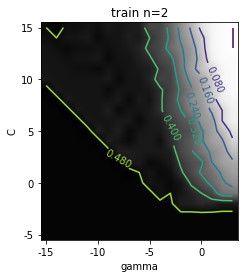

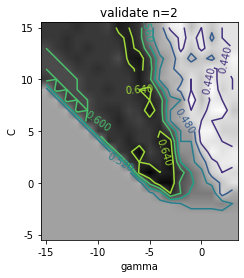

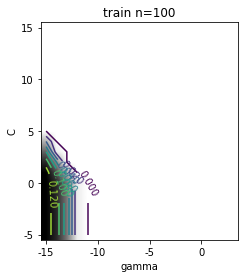

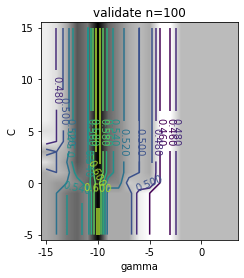

In [13]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# Vaš kôd ovdje...

# stvaranje skupa X i skupa y za n = 2
X_3b_2, y_3b_2 = make_classification(n_samples=200, n_features=2, n_informative=2, n_redundant=0, 
                                 n_repeated=0, n_classes=2, 
                                 n_clusters_per_class=2)

X_train_3b_2, X_validate_3b_2 = train_test_split(X_3b_2, test_size = 0.5) # razdvajanje X na X_train i X_validate 
y_train_3b_2, y_validate_3b_2 = train_test_split(y_3b_2, test_size = 0.5) # razdvajanje y na y_train i y_validate

# izracun najboljeg C i GAMMA te izracun svih pogreska na skupu train i validate 
bestC_2, bestG_2, train_2, validate_2 = grid_search(X_train_3b_2, X_validate_3b_2, 
                                                    y_train_3b_2, y_validate_3b_2,
                                                    c_range=(-5,15), g_range=(-15,3), 
                                                    error_surface=True)

print("n = 2 : best C = {}, best G = {}".format(bestC_2, bestG_2)) # ispis najboljeg C i GAMMA za n = 2

# iscrtanjanje pograske na skupu train
plt.figure()
plt.title("train n=2")
plot_error_surface(train_2, c_range=(-5,15), g_range=(-15,3))


# iscrtanjanje pograske na skupu validate
plt.figure()
plt.title("validate n=2")
plot_error_surface(validate_2, c_range=(-5,15), g_range=(-15,3))

#============================================================================================================
# stvaranje skupa X i skupa y za n = 100
X_3b_100, y_3b_100 = make_classification(n_samples=200, n_features=100, n_informative=100, n_redundant=0, 
                                 n_repeated=0, n_classes=2, n_clusters_per_class=2)


X_train_3b_100, X_validate_3b_100 = train_test_split(X_3b_100, test_size = 0.5)  # razdvajanje X na X_train i X_validate 
y_train_3b_100, y_validate_3b_100 = train_test_split(y_3b_100, test_size = 0.5)  # razdvajanje y na y_train i y_validate 

# izracun najboljeg C i GAMMA te izracun svih pogreska na skupu train i validate 
bestC_100, bestG_100, train_100, validate_100 = grid_search(X_train_3b_100, X_validate_3b_100,
                                                            y_train_3b_100, y_validate_3b_100,
                                                            c_range=(-5,15), g_range=(-15,3), 
                                                            error_surface=True)

print("n = 100 : best C = {}, best G = {}".format(bestC_100, bestG_100)) # ispis najboljeg C i GAMMA za n = 100

# iscrtanjanje pograske na skupu train
plt.figure()
plt.title("train n=100")
plot_error_surface(train_100, c_range=(-5,15), g_range=(-15,3))


# iscrtanjanje pograske na skupu train
plt.figure()
plt.title("validate n=100")
plot_error_surface(validate_100, c_range=(-5,15), g_range=(-15,3))


print()

**Q:** Razlikuje li se površina pogreške na skupu za učenje i skupu za ispitivanje? Zašto?  
**Q:** U prikazu površine pogreške, koji dio površine odgovara prenaučenosti, a koji podnaučenosti? Zašto?  
**Q:** Kako broj dimenzija $n$ utječe na površinu pogreške, odnosno na optimalne hiperparametre $(C^*, \gamma^*)$?  
**Q:** Preporuka je da povećanje vrijednosti za $\gamma$ treba biti popraćeno smanjenjem vrijednosti za $C$. Govore li vaši rezultati u prilog toj preporuci? Obrazložite.  

### 4. Utjecaj standardizacije značajki kod SVM-a

U prvoj laboratorijskoj vježbi smo pokazali kako značajke različitih skala mogu onemogućiti interpretaciju naučenog modela linearne regresije. Međutim, ovaj problem javlja se kod mnogih modela pa je tako skoro uvijek bitno prije treniranja skalirati značajke, kako bi se spriječilo da značajke s većim numeričkim rasponima dominiraju nad onima s manjim numeričkim rasponima. To vrijedi i za SVM, kod kojega skaliranje nerijetko može znatno poboljšati rezultate. Svrha ovog zadataka jest eksperimentalno utvrditi utjecaj skaliranja značajki na točnost SVM-a.

Generirat ćemo dvoklasni skup od $N=500$ primjera s $n=2$ značajke, tako da je dimenzija $x_1$ većeg iznosa i većeg raspona od dimenzije $x_0$, te ćemo dodati jedan primjer koji vrijednošću značajke $x_1$ odskače od ostalih primjera:

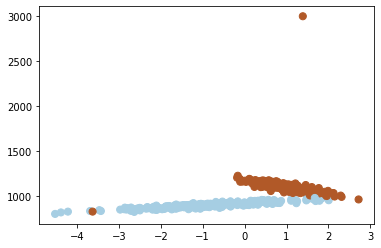

In [14]:
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=500,n_features=2,n_classes=2,n_redundant=0,n_clusters_per_class=1, random_state=69)
X[:,1] = X[:,1]*100+1000
X[0,1] = 3000

plot_2d_svc_problem(X, y)

#### (a)

Proučite funkciju za iscrtavanje histograma [`hist`](http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.hist). Prikažite histograme vrijednosti značajki $x_0$ i $x_1$ (ovdje i u sljedećim zadatcima koristite `bins=50`).

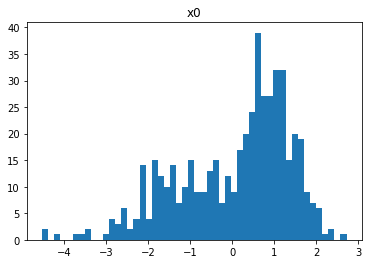

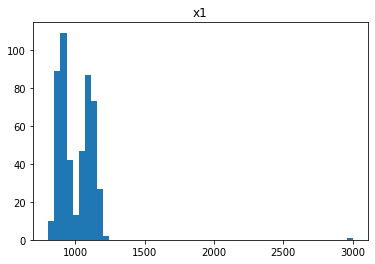

In [15]:
# Vaš kôd ovdje...

X_0_4a = [] # skup vrijednosti znacajki x0
X_1_4a = [] # skup vrijednosti znacajki x1

# razdvajanje X na skup x0 i x1
for i in range(len(X)):
    X_0_4a.append(X[i][0])
    
    X_1_4a.append(X[i][1])

# iscrtavanje histograma za skup x0
plt.figure()
plt.title("x0")
hist(X_0_4a, bins=50)
#=================================================

# iscrtavanje histograma za skup x1
plt.figure()
plt.title("x1")
hist(X_1_4a, bins=50)
print()


#### (b)

Proučite razred [`preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html). Prikažite histograme vrijednosti značajki $x_0$ i $x_1$ ako su iste skalirane min-max skaliranjem (ukupno dva histograma).

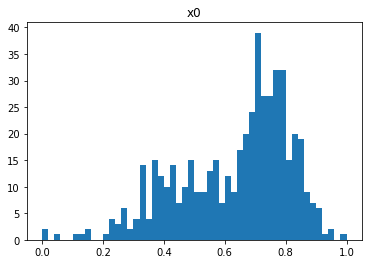

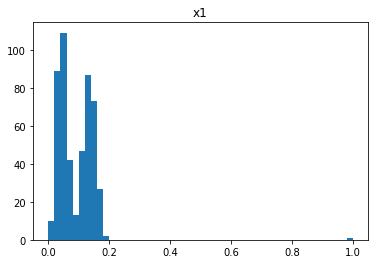

In [16]:
from sklearn.preprocessing import MinMaxScaler

# Vaš kôd ovdje...

scaler_4b = MinMaxScaler() # stvaranje objekta iz razreda MinMaxScalera 

scaler_4b.fit(X) # trazenje min i max skupa X za daljnje skaliranje

X_4b_scaled = scaler_4b.transform(X) # skaliranje skupa X

X_0_4b = [] # skup vrijednosti znacajki x0
X_1_4b = [] # skup vrijednosti znacajki x1

# razdvajanje X na skup x0 i x1
for i in range(len(X_4b_scaled)):
    X_0_4b.append(X_4b_scaled[i][0])
    
    X_1_4b.append(X_4b_scaled[i][1])

# iscrtavanje histograma za skup x0
plt.figure()
plt.title("x0")
hist(X_0_4b, bins=50)
#=================================================

# iscrtavanje histograma za skup x1
plt.figure()
plt.title("x1")
hist(X_1_4b, bins=50)
print()

**Q:** Kako radi ovo skaliranje? <br>
**Q:** Dobiveni histogrami su vrlo slični. U čemu je razlika? <br>

#### (c)

Proučite razred [`preprocessing.StandardScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html). Prikažite histograme vrijednosti značajki $x_0$ i $x_1$ ako su iste skalirane standardnim skaliranjem (ukupno dva histograma).

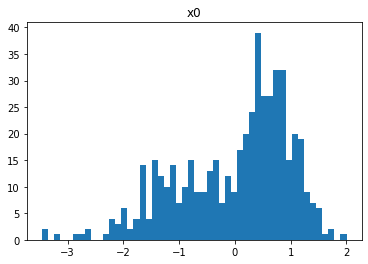

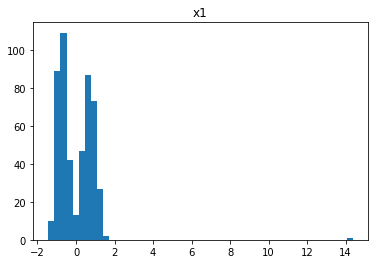

In [17]:
from sklearn.preprocessing import StandardScaler

# Vaš kôd ovdje...

scaler_4c = StandardScaler() # stvaranje objekta iz razreda StandardScalera 

scaler_4c.fit(X) # trazenje srednje vrijednosti skupa X za daljnje skaliranje

X_4c_scaled = scaler_4c.transform(X) # skaliranje skupa X

X_0_4c = [] # skup vrijednosti znacajki x0
X_1_4c = [] # skup vrijednosti znacajki x1

# razdvajanje X na skup x0 i x1
for i in range(len(X_4c_scaled)):
    X_0_4c.append(X_4c_scaled[i][0])
    
    X_1_4c.append(X_4c_scaled[i][1])

# iscrtavanje histograma za skup x0
plt.figure()
plt.title("x0")
hist(X_0_4c, bins=50)
#=================================================

# iscrtavanje histograma za skup x1
plt.figure()
plt.title("x1")
hist(X_1_4c, bins=50)
print()

**Q:** Kako radi ovo skaliranje? <br>
**Q:** Dobiveni histogrami su vrlo slični. U čemu je razlika? <br>

#### (d)

Podijelite skup primjera na skup za učenje i skup za ispitivanje u omjeru 1:1. Trenirajte SVM s jezgrenom funkcijom RBF na skupu za učenje i ispitajte točnost modela na skupu za ispitivanje, koristeći tri varijante gornjeg skupa: neskalirane značajke, standardizirane značajke i min-max skaliranje. Koristite podrazumijevane vrijednosti za $C$ i $\gamma$. Izmjerite točnost svakog od triju modela na skupu za učenje i skupu za ispitivanje. Ponovite postupak više puta (npr. 30) te uprosječite rezultate (u svakom ponavljanju generirajte podatke kao što je dano na početku ovog zadatka).

**NB:** Na skupu za učenje treba najprije izračunati parametre skaliranja te zatim primijeniti skaliranje (funkcija `fit_transform`), dok na skupu za ispitivanje treba samo primijeniti skaliranje s parametrima koji su dobiveni na skupu za učenje (funkcija `transform`).

In [18]:
# Vaš kôd ovdje...

n = 30 # definiranje vrijednosti n

NOT_SCALED_train = [] # tocnost modela na skupu train bez skaliranja

NOT_SCALED_validate = [] # tocnost modela na skupu validate bez skaliranja

MIN_MAX_SCALED_train = [] # tocnost modela na skupu train sa min max skaliranjem

MIN_MAX_SCALED_validate = [] # tocnost modela na skupu validate sa min max skaliranjem

STANDARD_SCALED_train = [] # tocnost modela na skupu train sa standard skaliranjem

STANDARD_SCALED_validate = [] # tocnost modela na skupu validate sa standard skaliranjem


for i in range(n):
    
    # stvaranje skupa X i y
    X_4d, y_4d = make_classification(n_samples=500,n_features=2,n_classes=2,n_redundant=0,n_clusters_per_class=1, random_state=69)
    X[:,1] = X[:,1]*100+1000
    X[0,1] = 3000
    
    X_train_4d, X_validate_4d = train_test_split(X_4d, test_size = 0.5) # razdvajanje X na X_train i X_validate 
    y_train_4d, y_validate_4d = train_test_split(y_4d, test_size = 0.5) # razdvajanje y na y_train i y_validate 
    #===============================================================================
   
    # definiranje SVC-a s radijalnom jezgrenom funkcijom
    svc_rbf_4d = SVC(kernel = 'rbf') 
    svc_rbf_4d.fit(X_train_4d, y_train_4d) # trenirajne modela
    
    h_train_4d = svc_rbf_4d.predict(X_train_4d) # izracun h(X) za skup train
    
    h_validate_4d = svc_rbf_4d.predict(X_validate_4d) # izracun h(X) za skup validate
    
    no_scaled_accuracy_train = accuracy_score(y_train_4d, h_train_4d) # izracun greske za skup train
    
    no_scaled_accuracy_validate = accuracy_score(y_validate_4d, h_validate_4d) # izracun greske za skup validate
    
    NOT_SCALED_train.append(no_scaled_accuracy_train) # dodavanje greske za skup train
    NOT_SCALED_validate.append(no_scaled_accuracy_validate) # dodavanje greske za skup validate
    #===============================================================================
    
    min_max_scaler_4d = MinMaxScaler() # stvaranje objekta iz razreda MinMaxScalera 
   
    X_train_4d_mms = min_max_scaler_4d.fit_transform(X_train_4d) # skaliranje skupa train
    
    X_validate_4d_mms = min_max_scaler_4d.transform(X_validate_4d) # skaliranje skupa validate
     
    # definiranje SVC-a s radijalnom jezgrenom funkcijom
    svc_rbf_4d_mms = SVC(kernel = 'rbf') 
    svc_rbf_4d_mms.fit(X_train_4d_mms, y_train_4d) # trenirajne modela
    
    h_train_4d_mms = svc_rbf_4d.predict(X_train_4d) # izracun h(X) za skup train
    
    h_validate_4d_mms = svc_rbf_4d_mms.predict(X_validate_4d_mms) # izracun h(X) za skup validate
    
    mms_scaled_accuracy_train = accuracy_score(y_train_4d, h_train_4d_mms) # izracun greske za skup train
    
    mms_scaled_accuracy_validate = accuracy_score(y_validate_4d, h_validate_4d_mms) # izracun greske za skup validate
    
    MIN_MAX_SCALED_train.append(mms_scaled_accuracy_train) # dodavanje greske za skup train
    MIN_MAX_SCALED_validate.append(mms_scaled_accuracy_validate) # dodavanje greske za skup validate
    #===============================================================================
    
    standard_scaler_4d = StandardScaler() # stvaranje objekta iz razreda StandardScalera 
    
    X_train_4d_ss = standard_scaler_4d.fit_transform(X_train_4d) # skaliranje skupa train
    
    X_validate_4d_ss = standard_scaler_4d.transform(X_validate_4d) # skaliranje skupa validate
    
    # definiranje SVC-a s radijalnom jezgrenom funkcijom
    svc_rbf_4d_ss = SVC(kernel = 'rbf')
    svc_rbf_4d_ss.fit(X_train_4d_ss, y_train_4d) # trenirajne modela
    
    h_train_4d_ss = svc_rbf_4d_ss.predict(X_train_4d_ss) # izracun h(X) za skup train
    
    h_validate_4d_ss = svc_rbf_4d_ss.predict(X_validate_4d_ss) # izracun h(X) za skup validate
    
    ss_scaled_accuracy_train = accuracy_score(y_train_4d, h_train_4d_ss) # izracun greske za skup train
    
    ss_scaled_accuracy_validate = accuracy_score(y_validate_4d, h_validate_4d_ss) # izracun greske za skup validate
    
    STANDARD_SCALED_train.append(ss_scaled_accuracy_train) # dodavanje greske za skup train
    STANDARD_SCALED_validate.append(ss_scaled_accuracy_validate) # dodavanje greske za skup validate
    #===============================================================================
    
    
# ispis srednje vrednosti preciznosti za skup train bez skaliranje    
print("Not scaled train accuracy: {}\n".format(average(NOT_SCALED_train)))

# ispis srednje vrednosti preciznosti za skup validate bez skaliranje
print("Not scaled validate accuracy: {}\n".format(average(NOT_SCALED_validate))) 
#===============================================================================

# ispis srednje vrednosti preciznosti za skup train sa minmax skaliranjem 
print("MinMax scaled train accuracy: {}\n".format(average(MIN_MAX_SCALED_train)))

# ispis srednje vrednosti preciznosti za skup validate sa minmax skaliranjem 
print("MinMax scaled validate accuracy: {}\n".format(average(MIN_MAX_SCALED_validate)))
#===============================================================================

# ispis srednje vrednosti preciznosti za skup train sa standard skaliranjem
print("Standrad scaled train accuracy: {}\n".format(average(STANDARD_SCALED_train)))

# ispis srednje vrednosti preciznosti za skup validate sa standard skaliranjem
print("Standrad scaled validate accuracy: {}\n".format(average(STANDARD_SCALED_validate)))

Not scaled train accuracy: 0.5622666666666667

Not scaled validate accuracy: 0.4878666666666666

MinMax scaled train accuracy: 0.5622666666666667

MinMax scaled validate accuracy: 0.4902666666666667

Standrad scaled train accuracy: 0.5630666666666666

Standrad scaled validate accuracy: 0.48800000000000004



**Q:** Jesu li rezultati očekivani? Obrazložite. <br>
**Q:** Bi li bilo dobro kada bismo funkciju `fit_transform` primijenili na cijelom skupu podataka? Zašto? Bi li bilo dobro kada bismo tu funkciju primijenili zasebno na skupu za učenje i zasebno na skupu za ispitivanje? Zašto?

### 5. Algoritam k-najbližih susjeda

U ovom zadatku promatrat ćemo jednostavan klasifikacijski model imena **algoritam k-najbližih susjeda**. Najprije ćete ga samostalno isprogramirati kako biste se detaljno upoznali s radom ovog modela, a zatim ćete prijeći na analizu njegovih hiperparametara (koristeći ugrađeni razred, radi efikasnosti).

#### (a)

Implementirajte klasu `KNN`, koja implementira algoritam $k$ najbližih susjeda. Neobavezan parametar konstruktora jest broj susjeda `n_neighbours` ($k$), čija je podrazumijevana vrijednost 3. Definirajte metode `fit(X, y)` i `predict(X)`, koje služe za učenje modela odnosno predikciju. Kao mjeru udaljenosti koristite euklidsku udaljenost ([`numpy.linalg.norm`](https://numpy.org/doc/stable/reference/generated/numpy.linalg.norm.html); pripazite na parametar `axis`). Nije potrebno implementirati nikakvu težinsku funkciju.

In [20]:
from numpy.linalg import norm

class KNN:
    def __init__(self, n_neighbors=3):
        # Vaš kôd ovdje...
        self.n_neighbors = n_neighbors
       
    def fit(self, X_train, y_train):
        # Vaš kôd ovdje...
        self.X_train = X_train
        self.y_train = y_train
        
    def predict(self, X_test):
        # Vaš kôd ovdje...
       
        Y = np.ndarray(shape = (len(X_test)))
        
        for w in range(len(X_test)):
            distances = np.ndarray(shape = (len(self.X_train)))
            
            # racunanje udaljenosti tocke sa tockama modela
            for i in range(len(self.X_train)):

                x0 = self.X_train[i][0]
                y0 = self.X_train[i][1]

                x1 = X_test[w][0]
                y1 = X_test[w][1]

                A = [x1 - x0, y1 - y0]

                dist = norm(A)
                

                distances[i] = dist
            #===================================================================
            
            min_distances = np.ndarray(shape = (self.n_neighbors))

            
            for i in range(len(min_distances)):
                min_distances[i] = inf

            # pronalaznje n najmanjih udaljenosti
            for i in range(len(distances)):

                for j in range(len(min_distances)):

                    if min_distances[j] > distances[i]:

                        min_distances[j] = distances[i]
                        break;
            #===================================================================
            
            min_index = np.ndarray(shape = (self.n_neighbors))

            for i in range(len(min_index)):
                min_index[i] = inf

            # pronalaznje n najmanjih indexa 
            for i in range(len(min_distances)):
                for j in range(len(distances)):
                    if min_distances[i] == distances[j] and (j not in min_index):
                        min_index[i] = j
                        break


            
            # stravanje skupa najblizih susjeda
            neighbors_y = np.ndarray(shape = (self.n_neighbors))
           
            for i in range(len(min_index)):
                index = int(min_index[i])
                neighbors_y[i] = self.y_train[index]

             # racunanje vrijdnosti y naprema susjedima tocke
            u, c = np.unique(neighbors_y, return_counts=True)

            new_y = u[c.argmax()]
            Y[w] = int(new_y)
        
        return Y

#### (b)

Kako biste se uvjerili da je Vaša implementacija ispravna, usporedite ju s onom u razredu [`neighbors.KNeighborsClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html). Budući da spomenuti razred koristi razne optimizacijske trikove pri pronalasku najboljih susjeda, obavezno postavite parametar `algorithm=brute`, jer bi se u protivnom moglo dogoditi da vam se predikcije razlikuju. Usporedite modele na danom (umjetnom) skupu podataka (prisjetite se kako se uspoređuju polja; [`numpy.all`](https://numpy.org/doc/stable/reference/generated/numpy.all.html)).

In [23]:
from sklearn.neighbors import KNeighborsClassifier

# Vaš kôd ovdje...

X_train_5b, X_validate_5b = train_test_split(X_art, test_size = 0.5) # razdvajanje X na X_train i X_validate 
y_train_5b, y_validate_5b = train_test_split(y_art, test_size = 0.5) # razdvajanje y na y_train i y_validate 

#===============================================================================

# koristrenje razreda neighbors.KNeighborsClassifier

neigh_5b = KNeighborsClassifier(n_neighbors=3, algorithm='brute') # stvaranje modela KNN sa paretrom algorithm='brute'
neigh_5b.fit(X_train_5b, y_train_5b) # treniranje modela

h_neigh_5b = neigh_5b.predict(X_validate_5b) # izracun h(X) za skup validate

print(h_neigh_5b) # ispis skupa h(x)

print(accuracy_score(h_neigh_5b, y_validate_5b)) # ispis preciznosti modela nad skupom validate

#===============================================================================

# koristrenje razreda kojeg sam implementirao

knn_5b = KNN(n_neighbors=3) # stvaranje modela KNN kojeg sam ja implementirao
knn_5b.fit(X_train_5b, y_train_5b) # treniranje modela

h_knn_5b = knn_5b.predict(X_validate_5b) # izracun h(X) za skup validate s mojim modelom

print(h_knn_5b) # ispis skupa h(x) s mojim modelom

print(accuracy_score(h_knn_5b, y_validate_5b)) # ispis preciznosti modela nad skupom validate s mojiim modelom

print(np.all(h_neigh_5b == h_knn_5b)) # uspodba dvaju modela

[1 1 0 0 1 0 0 0 1 1 1 1 1 0 0 1 0 0 1 0 1 0 1 1 0 1 1 0 0 1 1 1 1 0 1 1 1
 1 1 1 0 0 0 0 1 0 1 1 1 0]
0.58
[0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0.
 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 1. 1.
 1. 0.]
0.62
False


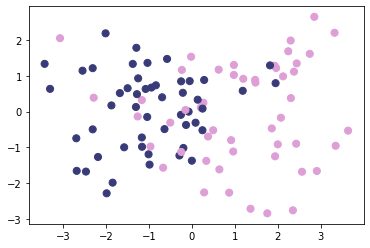

In [22]:
from sklearn.datasets import make_classification
X_art, y_art = make_classification(n_samples=100, n_features=2, n_classes=2, 
                                   n_redundant=0, n_clusters_per_class=2,
                                   random_state=69)
plot_2d_clf_problem(X_art, y_art)

### 6. Analiza algoritma k-najbližih susjeda

Algoritam k-nn ima hiperparametar $k$ (broj susjeda). Taj hiperparametar izravno utječe na složenost algoritma, pa je stoga izrazito važno dobro odabrati njegovu vrijednost. Kao i kod mnogih drugih algoritama, tako i kod algoritma k-nn optimalna vrijednost hiperametra $k$ ovisi o konkretnom problemu, uključivo broju primjera $N$, broju značajki (dimenzija) $n$ te broju klasa $K$. 

Kako bismo dobili pouzdanije rezultate, potrebno je neke od eksperimenata ponoviti na različitim skupovima podataka i zatim uprosječiti dobivene vrijednosti pogrešaka. Koristite funkciju: `knn_eval` koja trenira i ispituje model k-najbližih susjeda na ukupno `n_instances` primjera, i to tako da za svaku vrijednost hiperparametra iz zadanog intervala `k_range` ponovi `n_trials` mjerenja, generirajući za svako od njih nov skup podataka i dijeleći ga na skup za učenje i skup za ispitivanje. Udio skupa za ispitivanje definiran je parametrom `test_size`. Povratna vrijednost funkcije jest četvorka `(ks, best_k, train_errors, test_errors)`. Vrijednost `best_k` je optimalna vrijednost hiperparametra $k$ (vrijednost za koju je pogreška na skupu za ispitivanje najmanja). Vrijednosti `train_errors` i `test_errors`  liste su pogrešaka na skupu za učenja odnosno skupu za testiranje za sve razmatrane vrijednosti hiperparametra $k$, dok `ks` upravo pohranjuje sve razmatrane vrijednosti hiperparametra $k$.

#### (a)

Na podatcima iz zadatka 5, pomoću funkcije `plot_2d_clf_problem` iscrtajte prostor primjera i područja koja odgovaraju prvoj odnosno drugoj klasi. Ponovite ovo za $k\in[1, 5, 20, 100]$. 

**NB:** Implementacija algoritma `KNeighborsClassifier` iz paketa `scikit-learn` vjerojatno će raditi brže od Vaše implementacije, pa u preostalim eksperimentima koristite nju.

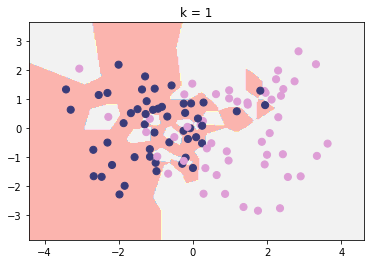

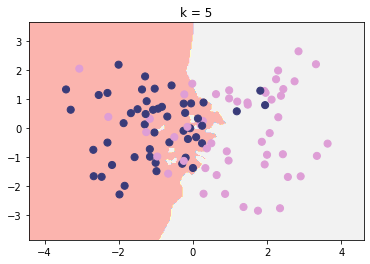

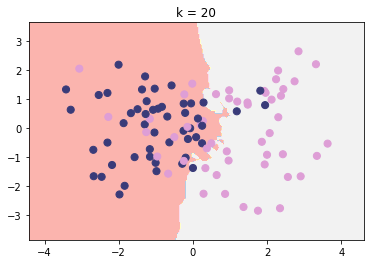

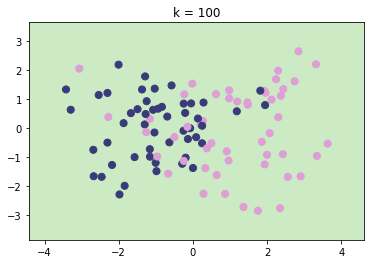

In [24]:
# Vaš kôd ovdje...

K_6a = [1, 5, 20, 100] # definiranje skupa svih vrijednosti k

for i in range(len(K_6a)):
    k = K_6a[i]
    neigh_6a = KNeighborsClassifier(n_neighbors=k, algorithm='brute') # stvaranje modela KNN za svaki k
    neigh_6a.fit(X_art, y_art) # treniranje modela
    
    # iscrtavanje podataka za svaki k
    plt.figure()
    plt.title("k = {}".format(k))
    plot_2d_clf_problem(X_art, y_art, neigh_6a.predict)

**Q:** Kako $k$ utječe na izgled granice između klasa?  
**Q:** Kako se algoritam ponaša u ekstremnim situacijama: $k=1$ i $k=100$?

#### (b)

Pomoću funkcije `knn_eval`, iscrtajte pogreške učenja i ispitivanja kao funkcije hiperparametra $k\in\{1,\dots,20\}$, za $N=\{100, 250, 750\}$ primjera. Načinite 3 zasebna grafikona. Za svaki ispišite optimalnu vrijednost hiperparametra $k$ (najlakše kao naslov grafikona; vidi [`plt.title`](https://matplotlib.org/devdocs/api/_as_gen/matplotlib.pyplot.title.html)).

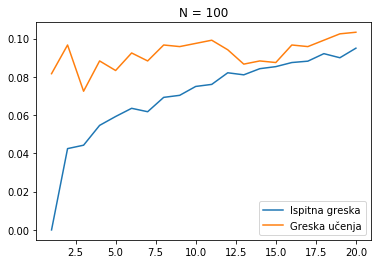

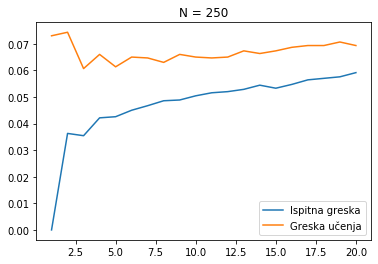

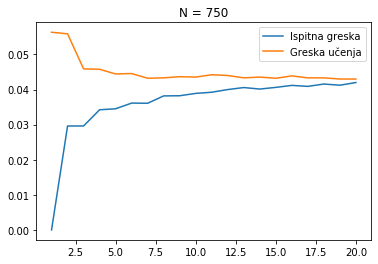

In [25]:
# Vaš kôd ovdje...

N_6b = [100, 250, 750] # definiranje skupa svih vrijednosti N

for i in range(len(N_6b)):
    n = N_6b[i]
    # izracun vrijednosti pogreške učenja i ispitivanja za pojedini n
    ks, best_k, train_errors, test_errors = knn_eval(n_instances = n) 
    
    # iscrtavanje pogreške učenja i ispitivanja za svaki n
    plt.figure()
    plt.plot(ks, train_errors, ks, test_errors)
    plt.title("N = {}".format(n))
    plt.legend(['Ispitna greska', 'Greska učenja'], loc="best")
    

**Q:** Kako se mijenja optimalna vrijednost hiperparametra $k$ s obzirom na broj primjera $N$? Zašto?  
**Q:** Kojem području odgovara prenaučenost, a kojem podnaučenost modela? Zašto?  
**Q:** Je li uvijek moguće doseći pogrešku od 0 na skupu za učenje?

#### (c)

Kako bismo provjerili u kojoj je mjeri algoritam k-najbližih susjeda osjetljiv na prisustvo nebitnih značajki, možemo iskoristiti funkciju [`datasets.make_classification`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html) kako bismo generirali skup primjera kojemu su neke od značajki nebitne. Naime, parametar `n_informative` određuje broj bitnih značajki, dok parametar `n_features` određuje ukupan broj značajki. Ako je `n_features > n_informative`, onda će neke od značajki biti nebitne. Umjesto da izravno upotrijebimo funkciju `make_classification`, upotrijebit ćemo funkciju `knn_eval`, koja samo preuzime ove parametre, ali nam omogućuje pouzdanije procjene.

Koristite funkciju `mlutils.knn_eval` na dva načina. U oba koristite $N=1000$ primjera, $n=10$ značajki i $K=5$ klasa, ali za prvi neka su svih 10 značajki bitne, a za drugi neka je bitno samo 5 od 10 značajki. Ispišite pogreške učenja i ispitivanja za oba modela za optimalnu vrijednost $k$ (vrijednost za koju je ispitna pogreška najmanja).

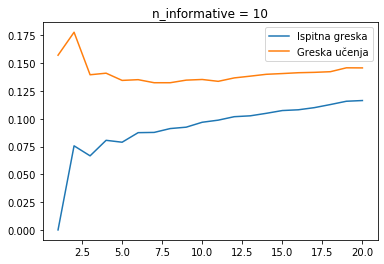

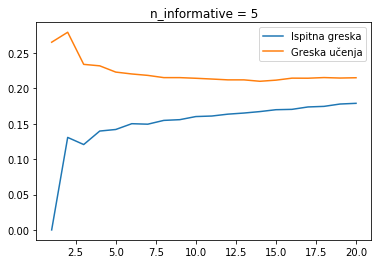

In [26]:
# Vaš kôd ovdje...

# izracun vrijednosti pogreške učenja i ispitivanja n = 10 zanacajki i n = 10 bitnih
ks_6c_10, best_k_6c_10, train_errors_6c_10, test_errors_6c_10 = knn_eval(n_instances = 1000, 
                                                                         n_features = 10, 
                                                                         n_classes = 5, 
                                                                         n_informative = 10)

# iscrtavanje pogreške učenja i ispitivanja za svaki n
plt.figure()
plt.plot(ks_6c_10, train_errors_6c_10, ks_6c_10, test_errors_6c_10)
plt.title("n_informative = 10")
plt.legend(['Ispitna greska', 'Greska učenja'], loc="best")
#===============================================================================

# izracun vrijednosti pogreške učenja i ispitivanja n = 10 zanacajki i n = 5 bitnih
ks_6c_5, best_k_6c_5, train_errors_6c_5, test_errors_6c_5 = knn_eval(n_instances = 1000, 
                                                                         n_features = 10, 
                                                                         n_classes = 5, 
                                                                        n_informative = 5)
# iscrtavanje pogreške učenja i ispitivanja za svaki n
plt.figure()
plt.plot(ks_6c_5, train_errors_6c_5, ks_6c_5, test_errors_6c_5)
plt.title("n_informative = 5")
plt.legend(['Ispitna greska', 'Greska učenja'], loc="best")
print("")

**Q:** Je li algoritam k-najbližih susjeda osjetljiv na nebitne značajke? Zašto?  
**Q:** Je li ovaj problem izražen i kod ostalih modela koje smo dosad radili (npr. logistička regresija)?  
**Q:** Kako bi se model k-najbližih susjeda ponašao na skupu podataka sa značajkama različitih skala? Detaljno pojasnite.

### 7. "Prokletstvo dimenzionalnosti"

"Prokletstvo dimenzionalnosti" zbirni je naziv za niz fenomena povezanih s visokodimenzijskim prostorima. Ti fenomeni, koji se uglavnom protive našoj intuiciji, u većini slučajeva dovode do toga da se s porastom broja dimenzija (značajki) smanjenje točnost modela.

Općenito, povećanje dimenzija dovodi do toga da sve točke u ulaznome prostoru postaju (u smislu euklidske udaljenosti) sve udaljenije jedne od drugih te se, posljedično, gube razlike u udaljenostima između točaka. Eksperimentalno ćemo provjeriti da je to doista slučaj. Proučite funkciju [`metrics.pairwise_distances`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise_distances.html). Generirajte 100 slučajnih vektora u različitim dimenzijama $n\in[1,2,\ldots,50]$ dimenzija te izračunajte *prosječnu* euklidsku udaljenost između svih parova tih vektora. Za generiranje slučajnih vektora koristite funkciju [`numpy.random.random`](https://numpy.org/doc/stable/reference/random/generated/numpy.random.random.html). Na istom grafu skicirajte i krivulju za prosječne kosinusne udaljenosti (parametar `metric`).

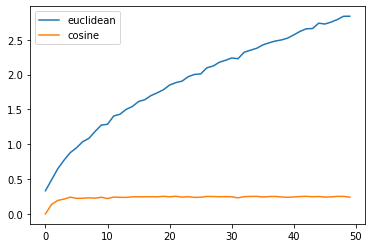

In [27]:
from sklearn.metrics.pairwise import pairwise_distances

# Vaš kôd ovdje...

n_7 = 50 # definiranje vrijednosi dimenzija n

number_of_vectors_7 = 100 # definiranje broja slucajnih vektora

EUCLIDEAN_7 = [] # definiranje skupa euclidskih udaljenosti
COSINE_7 = [] # definiranje skupa kosinusnih udaljenosti
for i in range(n_7):
    
    vectors_7 = [] # definiranje skupa vectora
    
    # nasumicno generiranje novih vectora 
    for j in range(number_of_vectors_7):
        vector_7 = np.random.random((i+1))
        vectors_7.append(vector_7)
    
    euclidean_7 = pairwise_distances(vectors_7, metric = 'euclidean')  # izracun euclidskih udaljenosti za vektor 
    cosine_7 = pairwise_distances(vectors_7, metric = 'cosine') # izracun kosinusih udaljenosti za vektor
    
    average_euclidean_7 = np.average(euclidean_7) # izracun srednje euclidske udaljenosti za vektor
    average_cosine_7 = np.average(cosine_7) # izracun srednje kosinusne udaljenosti za vektor
    
    EUCLIDEAN_7.append(average_euclidean_7) # dodavanje srednje euclidske udaljenosti u skup
    COSINE_7.append(average_cosine_7) # dodavanje srednje kosinusne udaljenosti za vektor

# iscrtavanje euclidske udaljenosti i kosinusne udaljenosti za svaki n
plt.figure()
plt.plot(range(n_7), EUCLIDEAN_7, range(n_7), COSINE_7)
plt.legend(['euclidean', 'cosine'], loc="best")
print()    

**Q:** Pokušajte objasniti razlike u rezultatima. Koju biste od ovih dviju mjera koristili za klasifikaciju visokodimenzijskih podataka?  
**Q:** Zašto je ovaj problem osobito izražen kod algoritma k-najbližih susjeda?